# Homework 3

## Baseline

In [201]:
import gzip
from collections import defaultdict
from sklearn import linear_model
import csv

def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d['user_id'],d['recipe_id'],d

## Cook/Make prediction

### Task 1

In [203]:
reviews = []

for _, _, review in readCSV("data/trainInteractions.csv.gz"):
  reviews.append(review)

train_reviews = reviews[:400000]
valid_reviews = reviews[400000:500000]

In [204]:
## Making validation-set
import random

valid_recipes_per_user = defaultdict(set)
recipes = set()
for review in valid_reviews:
    valid_recipes_per_user[review['user_id']].add(review['recipe_id'])
    recipes.add(review['recipe_id'])
recipes = list(recipes)

valid_dict = defaultdict(int)
for valid_review in valid_reviews:
    user = valid_review['user_id']
    recipe = valid_review['recipe_id']
    valid_dict[(user, recipe)] =  1
    neg_sample = random.choice(recipes)
    while neg_sample in valid_recipes_per_user[user] or (user, neg_sample) in valid_dict.keys():
        neg_sample = random.choice(recipes)
    valid_dict[(user, neg_sample)] =  0

In [205]:
recipe_count = defaultdict(int)
total_cooked = 0

for review in train_reviews:
  recipe_count[review['recipe_id']] += 1
  total_cooked += 1

def most_popular_recipes(treshold_percentile):
  most_popular = [(recipe_count[x], x) for x in recipe_count]
  most_popular.sort()
  most_popular.reverse()

  predict_true = set()
  count = 0
  for num, recipe_id in most_popular:
    count += num
    predict_true.add(recipe_id)
    if count > total_cooked*treshold_percentile: break
  
  return predict_true

In [206]:
##Predict the validation set
predict_true = most_popular_recipes(0.5)

pred_valid_dict = defaultdict(int)
for user, recipe in valid_dict.keys():
    pred_valid_dict[(user, recipe)] = (int(recipe in predict_true))


In [207]:
accuracy = sum((pred == valid) for pred, valid in zip(pred_valid_dict.values(), valid_dict.values()))/len(pred_valid_dict)
print(f"Accuracy of baseline model: {accuracy}")

Accuracy of baseline model: 0.613615


### Task 2

In [208]:
accuracies = {}

for i in range(20, 80 + 1):
    treshold_percentile = float(i)/100
    
    predict_true_2 = most_popular_recipes(treshold_percentile)

    pred_valid_dict_2 = defaultdict(int)
    for user, review in valid_dict.keys():
        pred_valid_dict_2[(user, review)] = review in predict_true_2

    accuracy = sum((pred == valid) for pred, valid in zip(pred_valid_dict_2.values(), valid_dict.values()))/len(valid_dict)
    accuracies[treshold_percentile] = accuracy

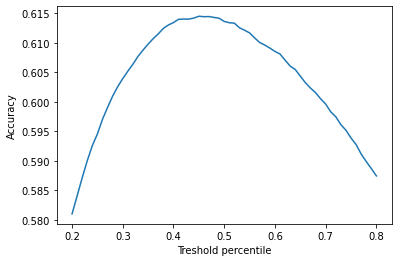

In [209]:
import matplotlib.pyplot as plt

x_plot = [treshold_percentile for treshold_percentile in accuracies.keys()]
y_plot = [acc for acc in accuracies.values()]

plt.xlabel("Treshold percentile")
plt.ylabel("Accuracy")
plt.plot(x_plot, y_plot)

In [210]:
predict_true_2 = most_popular_recipes(0.46)


pred_valid_dict_2 = defaultdict(int)
for user, review in valid_dict.keys():
    pred_valid_dict_2[(user, review)] = review in predict_true_2

accuracy = sum((pred == valid) for pred, valid in zip(pred_valid_dict_2.values(), valid_dict.values()))/len(valid_dict)
print(f"Based on the graph and output you can see that the optimal treshold \nlies at 0.46. You then get an accauracy of {accuracy}, which \nis marginally better than the baseline.")


Based on the graph and output you can see that the optimal treshold 
lies at 0.46. You then get an accauracy of 0.61442, which 
is marginally better than the baseline.


### Task 3

In [211]:
def Jaccard(s1, s2):
    numerator = len(s1.intersection(s2))
    denominator = len(s1.union(s2))
    if(denominator == 0):
        return 0
    return numerator/denominator

In [214]:
train_recipes_per_user = defaultdict(set)
train_users_per_recipe = defaultdict(set)
for review in train_reviews:
    user = review['user_id']
    recipe = review['recipe_id']
    train_recipes_per_user[user].add(recipe)
    train_users_per_recipe[recipe].add(user)

In [215]:
def max_Jaccard(user, recipe):
    max_similarity = 0
    for other_recipe in train_recipes_per_user[user]:
        jac = Jaccard(train_users_per_recipe[recipe], train_users_per_recipe[other_recipe])
        if jac > max_similarity:
            max_similarity = jac
    return max_similarity

In [216]:
maximum_jaccard = defaultdict(int)
for user, recipe in valid_dict.keys():
    maximum_jaccard[(user, recipe)] = max_Jaccard(user, recipe)

In [217]:
def predict_jaccard(treshold):
    pred_valid_dict_3 = defaultdict(int)
    for user, recipe in valid_dict.keys():
        max_jac = maximum_jaccard[(user, recipe)]
        pred_valid_dict_3[user, recipe] = max_jac > treshold
    return pred_valid_dict_3

In [218]:
accuracies = {}
tresholds = [float(i)/10 for i in range(20,160)]
for treshold in tresholds:
    pred_dict = predict_jaccard(treshold/1000)
    accuracy = sum((pred == valid) for pred, valid in zip(pred_dict.values(), valid_dict.values()))/len(valid_dict)
    accuracies[treshold/1000] = accuracy

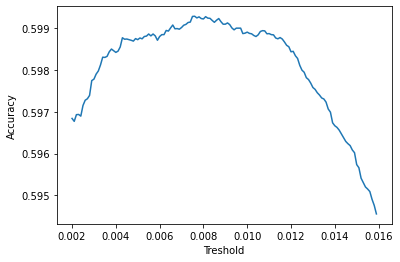

In [219]:
x_plot = [treshold for treshold in accuracies.keys()]
y_plot = [acc for acc in accuracies.values()]

plt.xlabel("Treshold")
plt.ylabel("Accuracy")
plt.plot(x_plot, y_plot)

In [220]:
pred_dict = predict_jaccard(0.008)
accuracy = sum((pred == valid) for pred, valid in zip(pred_dict.values(), valid_dict.values()))/len(valid_dict)

print(f"The best accuracy with Jaccard similarity was {accuracy}, with a treshold of {0.008}")

The best accuracy with Jaccard similarity was 0.59922, with a treshold of 0.008


### Task 4

In [221]:
def pred_jac_pop(jac_treshold, pop_treshold, prediction_list):
    pred_dict = defaultdict(int)
    N_most_popular = most_popular_recipes(pop_treshold)
    for user, recipe in prediction_list:
        max_jac = maximum_jaccard[(user, recipe)]

        if max_jac > jac_treshold or recipe in N_most_popular:
            pred_dict[(user, recipe)] = 1
        else:
            pred_dict[(user, recipe)] = 0
    
    return pred_dict


In [222]:
jac_treshold = 0.008
pop_treshold = 0.46

pred_valid_dict_4 = pred_jac_pop(jac_treshold, pop_treshold, pred_dict.keys())

accuracy = sum((pred == valid) for pred, valid in zip(pred_valid_dict_4.values(), valid_dict.values()))/len(valid_dict)
print(f"By combining the best tresholds from the two previous tasks, I managed to improve the predictor from task 3.")
print(f"The performance on the validation set had an accuracy of {accuracy}")

By combining the best tresholds from the two previous tasks, I managed to improve the predictor from task 3.
The performance on the validation set had an accuracy of 0.605275


### Task 5

In [223]:
header = ""
test_list = []
for line in open("data/stub_Made.txt"):
    if line.startswith("user_id"):
        header = line
        continue
    user, recipe = line.strip().split('-')
    test_list.append((user, recipe))

jac_treshold = 0.008
pop_treshold = 0.46
pred_test_dict = pred_jac_pop(jac_treshold, pop_treshold, test_list)

predictions = open("data/predictions_Made.txt", 'w')
predictions.write(header)
for key, pred in pred_test_dict.items():
    user, recipe = key
    predictions.write(f"{user}-{recipe},{pred}\n")

Solution uploaded to Kaggle, with an impressive prediction of 67%(!!), quite an improvement from the validation set. My Kaggle user name is henriklarssonhestnes, with Henrik Larsson Hestnes as display name.

## Rating prediction

### Task 9

In [224]:
reviews = []

for _, _, review in readCSV("data/trainInteractions.csv.gz"):
  reviews.append(review)

train_reviews = reviews[:400000]
valid_reviews = reviews[400000:500000]

In [232]:
valid_dict = defaultdict(int)
for valid_review in valid_reviews:
    user = valid_review['user_id']
    recipe = valid_review['recipe_id']
    rating = valid_review['rating']
    valid_dict[(user, recipe)] =  int(rating)

In [234]:
users_per_recipe = defaultdict(set)
recipes_per_user = defaultdict(set)
train_dict = defaultdict(int)
for train_review in train_reviews:
    user = train_review['user_id']
    recipe = train_review['recipe_id']
    rating = train_review['rating']
    train_dict[(user, recipe)] =  int(rating)
    recipes_per_user[user].add(recipe)
    users_per_recipe[recipe].add(user)

In [299]:
N = len(train_dict)

In [283]:
def calculate_alpha(data_dict, beta_user_dict, beta_item_dict, N):
    sum = 0
    for (user, item), rating in data_dict.items():
        sum += rating - (beta_user_dict[user] + beta_item_dict[item])
    return sum/N

def calculate_beta_user(data_dict, items_per_user, alpha, beta_item_dict, lamb):
    beta_user_dict = {}
    for user, items in items_per_user.items():
        sum = 0
        for item in items:
            rating = data_dict[(user, item)]
            beta_item = beta_item_dict[item]
            sum += rating - (alpha +beta_item)
        beta_user = sum / (lamb + len(items_per_user[user]))
        beta_user_dict[user] = beta_user
    return beta_user_dict

def calculate_beta_item(data_dict, users_per_item, alpha, beta_user_dict, lamb):
    beta_item_dict = {}
    for item, users in users_per_item.items():
        sum = 0
        for user in users:
            rating = data_dict[(user, item)]
            beta_user = beta_user_dict[user]
            sum += rating - (alpha + beta_user)
        beta_item = sum/(lamb + len(users_per_item[item]))
        beta_item_dict[item] = beta_item
    return beta_item_dict

In [315]:
beta_user_dict = {user:0 for user in recipes_per_user.keys()}
beta_recipe_dict = {recipe:0 for recipe in users_per_recipe.keys()}
x=[]
y_alpha = []
y_bu = []
y_bi = []

lamb = 1
for i in range(250):
    alpha = calculate_alpha(train_dict, beta_user_dict, beta_recipe_dict, N)
    beta_user_dict = calculate_beta_user(train_dict, recipes_per_user, alpha, beta_recipe_dict, lamb)
    beta_recipe_dict = calculate_beta_item(train_dict, users_per_recipe, alpha, beta_user_dict, lamb)
    x.append(i)
    y_alpha.append(alpha)
    y_bu.append(beta_user_dict['88348277'])
    y_bi.append(beta_recipe_dict['03969194'])


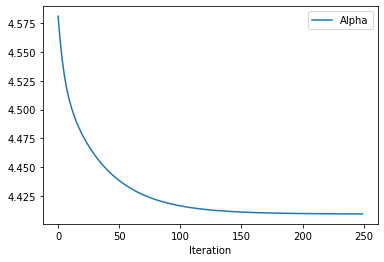

In [296]:
plt.xlabel("Iteration")
plt.plot(x, y_alpha, label='Alpha')
plt.legend()

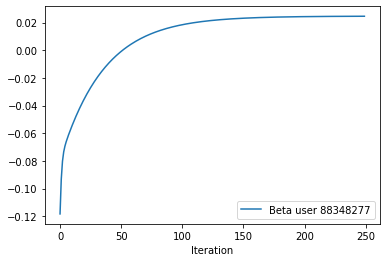

In [297]:
plt.xlabel("Iteration")
plt.plot(x, y_bu, label='Beta user 88348277')
plt.legend()

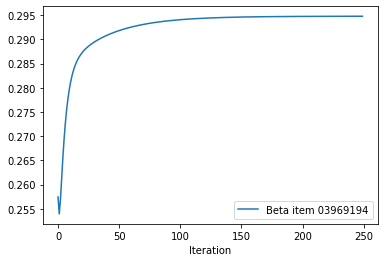

In [298]:
plt.xlabel("Iteration")
plt.plot(x, y_bi, label='Beta item 03969194')
plt.legend()

In [305]:
def MSE(predicted, validation):
    mse = 0
    for (user, recipe), review in predicted.items():
        mse += (review - validation[(user, recipe)])**2
    return mse/len(predicted)

In [304]:
pred_valid_dict_9 = defaultdict(int)
for user, recipe in valid_dict.keys():
    beta_user = beta_user_dict[user] if user in beta_user_dict else 0
    beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
    pred_valid_dict_9[(user, recipe)] = alpha + beta_user + beta_recipe

In [309]:
mse = MSE(pred_valid_dict_9, valid_dict)
print(f"MSE on the validation set: {mse}")

MSE on the validation set: 0.8803365761991694


### Task 10

In [314]:
import math

user_lowest_value = math.inf
user_lowest_id = 0
user_highest_value = -math.inf
user_highest_id = 0

for user_id, beta_value in beta_user_dict.items():
    if beta_value > user_highest_value:
        user_highest_value = beta_value
        user_highest_id = user_id
    if beta_value < user_lowest_value:
        user_lowest_value = beta_value
        user_lowest_id = user_id

print(f"USER WITH SMALLEST BETA VALUE \nUser ID: {user_lowest_id}, Beta: {user_lowest_value}")
print(f"\nUSER WITH LARGEST BETA VALUE \nUser ID: {user_highest_id}, Beta: {user_highest_value}")


recipe_lowest_value = math.inf
recipe_lowest_id = 0
recipe_highest_value = -math.inf
recipe_highest_id = 0

for user_id, beta_value in beta_recipe_dict.items():
    if beta_value > recipe_highest_value:
        recipe_highest_value = beta_value
        recipe_highest_id = user_id
    if beta_value < recipe_lowest_value:
        recipe_lowest_value = beta_value
        recipe_lowest_id = user_id

print(f"\nRECIPE WITH SMALLEST BETA VALUE \nUser ID: {recipe_lowest_id}, Beta: {recipe_lowest_value}")
print(f"\nRECIPE WITH LARGEST BETA VALUE \nUser ID: {recipe_highest_id}, Beta: {recipe_highest_value}")


USER WITH SMALLEST BETA VALUE 
User ID: 33431946, Beta: -4.380481082331884

USER WITH LARGEST BETA VALUE 
User ID: 87153225, Beta: 1.1535736562941719

RECIPE WITH SMALLEST BETA VALUE 
User ID: 33777570, Beta: -3.3635207273494365

RECIPE WITH LARGEST BETA VALUE 
User ID: 14725150, Beta: 1.7529115477436843


### Task 11

In [316]:
## Tuning the lambda parameter by coarse-tuning
lamb = [0.01, 0.1, 1, 10]

for l in lamb:
    beta_user_dict = {user:0 for user in recipes_per_user.keys()}
    beta_recipe_dict = {recipe:0 for recipe in users_per_recipe.keys()}
    for i in range(100):
        alpha = calculate_alpha(train_dict, beta_user_dict, beta_recipe_dict, N)
        beta_user_dict = calculate_beta_user(train_dict, recipes_per_user, alpha, beta_recipe_dict, l)
        beta_recipe_dict = calculate_beta_item(train_dict, users_per_recipe, alpha, beta_user_dict, l)
    
    pred_valid_dict_11 = defaultdict(int)
    for user, recipe in valid_dict.keys():
        beta_user = beta_user_dict[user] if user in beta_user_dict else 0
        beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
        pred_valid_dict_11[(user, recipe)] = alpha + beta_user + beta_recipe
    
    mse = MSE(pred_valid_dict_11, valid_dict)

    print(f"MSE on the validation set with lambda={l}: {mse}")

MSE on the validation set with lambda=0.01: 1.024943027680394
MSE on the validation set with lambda=0.1: 0.9916221037025
MSE on the validation set with lambda=1: 0.8803862944245333
MSE on the validation set with lambda=10: 0.8198083327275589


In [317]:
## Tuning the lambda parameter by coarse-tuning
lamb = [5, 10, 15, 20]

for l in lamb:
    beta_user_dict = {user:0 for user in recipes_per_user.keys()}
    beta_recipe_dict = {recipe:0 for recipe in users_per_recipe.keys()}
    for i in range(100):
        alpha = calculate_alpha(train_dict, beta_user_dict, beta_recipe_dict, N)
        beta_user_dict = calculate_beta_user(train_dict, recipes_per_user, alpha, beta_recipe_dict, l)
        beta_recipe_dict = calculate_beta_item(train_dict, users_per_recipe, alpha, beta_user_dict, l)
    
    pred_valid_dict_11 = defaultdict(int)
    for user, recipe in valid_dict.keys():
        beta_user = beta_user_dict[user] if user in beta_user_dict else 0
        beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
        pred_valid_dict_11[(user, recipe)] = alpha + beta_user + beta_recipe
    
    mse = MSE(pred_valid_dict_11, valid_dict)

    print(f"MSE on the validation set with lambda={l}: {mse}")

MSE on the validation set with lambda=5: 0.8251550501406563
MSE on the validation set with lambda=10: 0.8198083327275589
MSE on the validation set with lambda=15: 0.8206888107391213
MSE on the validation set with lambda=20: 0.8227300591931039


In [318]:
## Tuning the lambda parameter by coarse-tuning
lamb = [9, 9.5, 10, 10.5, 11]

for l in lamb:
    beta_user_dict = {user:0 for user in recipes_per_user.keys()}
    beta_recipe_dict = {recipe:0 for recipe in users_per_recipe.keys()}
    for i in range(100):
        alpha = calculate_alpha(train_dict, beta_user_dict, beta_recipe_dict, N)
        beta_user_dict = calculate_beta_user(train_dict, recipes_per_user, alpha, beta_recipe_dict, l)
        beta_recipe_dict = calculate_beta_item(train_dict, users_per_recipe, alpha, beta_user_dict, l)
    
    pred_valid_dict_11 = defaultdict(int)
    for user, recipe in valid_dict.keys():
        beta_user = beta_user_dict[user] if user in beta_user_dict else 0
        beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
        pred_valid_dict_11[(user, recipe)] = alpha + beta_user + beta_recipe
    
    mse = MSE(pred_valid_dict_11, valid_dict)

    print(f"MSE on the validation set with lambda={l}: {mse}")

MSE on the validation set with lambda=9: 0.8200211338981331
MSE on the validation set with lambda=9.5: 0.8198874318795855
MSE on the validation set with lambda=10: 0.8198083327275589
MSE on the validation set with lambda=10.5: 0.8197752008430802
MSE on the validation set with lambda=11: 0.8197809489122868


In [321]:
print("After this trial and error procedure, I have found that the best MSE is with lambda=10.5")

lamb = 11
for i in range(100):
    alpha = calculate_alpha(train_dict, beta_user_dict, beta_recipe_dict, N)
    beta_user_dict = calculate_beta_user(train_dict, recipes_per_user, alpha, beta_recipe_dict, lamb)
    beta_recipe_dict = calculate_beta_item(train_dict, users_per_recipe, alpha, beta_user_dict, lamb)

pred_valid_dict_11 = defaultdict(int)
for user, recipe in valid_dict.keys():
    beta_user = beta_user_dict[user] if user in beta_user_dict else 0
    beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
    pred_valid_dict_11[(user, recipe)] = alpha + beta_user + beta_recipe

mse = MSE(pred_valid_dict_11, valid_dict)

print(f"MSE on the validation set with lambda={10.5}: {mse}")

After this trial and error procedure, I have found that the best MSE is with lambda=10.5
MSE on the validation set with lambda=10.5: 0.8197809488941853


In [324]:
header = ""
test_list = []
for line in open("data/stub_Rated.txt"):
    if line.startswith("user_id"):
        header = line
        continue
    user, recipe = line.strip().split('-')
    test_list.append((user, recipe))


pred_test_dict = defaultdict(int)

for (user, recipe) in test_list:
    beta_user = beta_user_dict[user] if user in beta_user_dict else 0
    beta_recipe = beta_recipe_dict[recipe] if recipe in beta_recipe_dict else 0
    pred_test_dict[(user, recipe)] = alpha + beta_user + beta_recipe

predictions = open("data/predictions_Rated.txt", 'w')
predictions.write(header)
for key, pred in pred_test_dict.items():
    user, recipe = key
    predictions.write(f"{user}-{recipe},{pred}\n")

Solution uploaded to Kaggle, and got an MSE of 0.8291. My Kaggle user name is henriklarssonhestnes, with Henrik Larsson Hestnes as display name.